In [1]:
## load libraries
suppressWarnings(suppressPackageStartupMessages(library(ggthemes)))
suppressWarnings(suppressPackageStartupMessages(library(ggplot2)))
suppressWarnings(suppressPackageStartupMessages(library(scran)))
suppressWarnings(suppressPackageStartupMessages(library(cowplot)))

In [2]:
col_day0 = canva_pal("Pool party")(4)[1]
col_day1 = canva_pal("Pool party")(4)[2]
col_day2 = canva_pal("Pool party")(4)[3]
col_day3 = canva_pal("Pool party")(4)[4]

col_ips = canva_pal("Modern and clean")(4)[2]
col_mesendo = canva_pal("Modern and clean")(4)[4]
col_defendo = canva_pal("Warm tones")(4)[3]

In [3]:
# load sceset
sce = readRDS("/hps/nobackup/hipsci/scratch/singlecell_endodiff/data_processed/merged/20180618/sce_merged_afterqc_filt_allexpts.rds")

In [4]:
sce

class: SingleCellExperiment 
dim: 11231 36044 
metadata(4): log.exprs.offset log.exprs.offset log.exprs.offset
  log.exprs.offset
assays(3): tpm counts logcounts
rownames(11231): ENSG00000000003_TSPAN6 ENSG00000000419_DPM1 ...
  ENSG00000272325_NUDT3 ENSG00000272398_CD24
rowData names(17): exprs_collapsed_to ensembl_transcript_id ...
  is_intop2000hvg is_hvg
colnames(36044): 21843_1#10 21843_1#100 ... 24539_8#97 24539_8#98
colData names(123): adj_x adj_y ... princ_curve princ_curve_scaled01
reducedDimNames(1): PCA
spikeNames(1): ERCC

In [24]:
rownames(sce)[grep("ELF2", rownames(sce))]

[1] "ENSG00000048740_CELF2" "ENSG00000109381_ELF2"

In [16]:
sce$pc1top500hvgs = p1$PC1_top500hvgs

In [15]:
sce$stage_pc1top500hvgs = "not assigned"
sce$stage_pc1top500hvgs[sce$day == "day0" & sce$pc1top500hvgs < -20] = "ips"
sce$stage_pc1top500hvgs[sce$day %in% c("day1","day2") & sce$pc1top500hvgs > -23 & sce$pc1top500hvgs < 4] = "mesendo"
sce$stage_pc1top500hvgs[sce$day %in% c("day2","day3") & sce$pc1top500hvgs > 22] = "defendo"

In [18]:
samples = data.frame(day = sce$day, experiment = sce$experiment, population = "cell", donor = sce$donor_short_id,
                    stage = sce$stage_pc1top500hvgs, pseudotime = range01(sce$pc1top500hvgs),
                    size_factor = sce$size_factor, cell = sce$cell_name)
head(samples)

day,experiment,population,donor,stage,pseudotime,size_factor,cell
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
day1,expt_09,cell,joxm_1,not assigned,0.3022399,1.4396132,21843_1#10
day1,expt_09,cell,fafq_1,not assigned,0.5042794,0.5073333,21843_1#100
day1,expt_09,cell,fafq_1,not assigned,0.4352490,1.2878409,21843_1#101
day1,expt_09,cell,wuye_2,not assigned,0.2695033,1.1027145,21843_1#102
day1,expt_09,cell,joxm_1,not assigned,0.3735655,0.9776976,21843_1#103
day1,expt_09,cell,iisa_3,not assigned,0.4149124,0.8910608,21843_1#105


In [22]:
write.table(samples,"/hps/nobackup/hipsci/scratch/singlecell_endodiff/data_processed/merged/20180618/sample_metadata.txt",
           quote = F, row.names = F, sep = "\t")

In [5]:
# normalize
sce <- normalize(sce)
# define design matrix with batch structure (experiment)
design <- model.matrix(~experiment, data = colData(sce))
# define highly variable genes
alt.fit <- trendVar(sce, design = design, use.spikes = FALSE)
alt.decomp <- decomposeVar(sce, alt.fit)

Warning message in .get_all_sf_sets(object):
“spike-in set 'ERCC' should have its own size factors”

In [6]:
# get top 500
top.500.hvgs <- rownames(alt.decomp[order(alt.decomp$bio, decreasing = TRUE),][1:500,])
# get PC1 from expression of the top 500 hvgs
sce_500hvg = sce[rownames(sce) %in% top.500.hvgs,]
p1 = as.data.frame(prcomp(t(logcounts(sce_500hvg)))$x[,1])
colnames(p1) = "PC1_top500hvgs"
head(p1)

,PC1_top500hvgs
,<dbl>
21843_1#10,-11.7695261
21843_1#100,5.1315308
21843_1#101,-0.6430211
21843_1#102,-14.5080208
21843_1#103,-5.8029849
21843_1#105,-2.3442226


In [8]:
range01 <- function(x){(x-min(x))/(max(x)-min(x))}

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


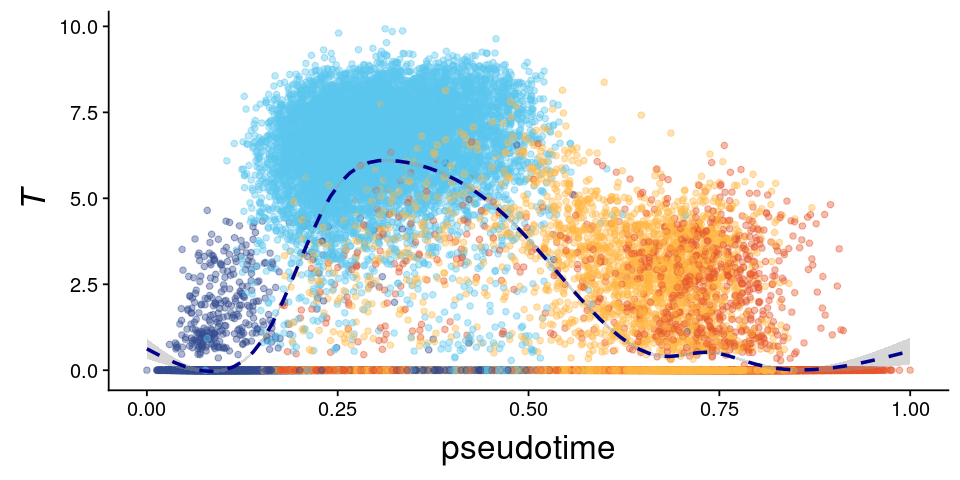

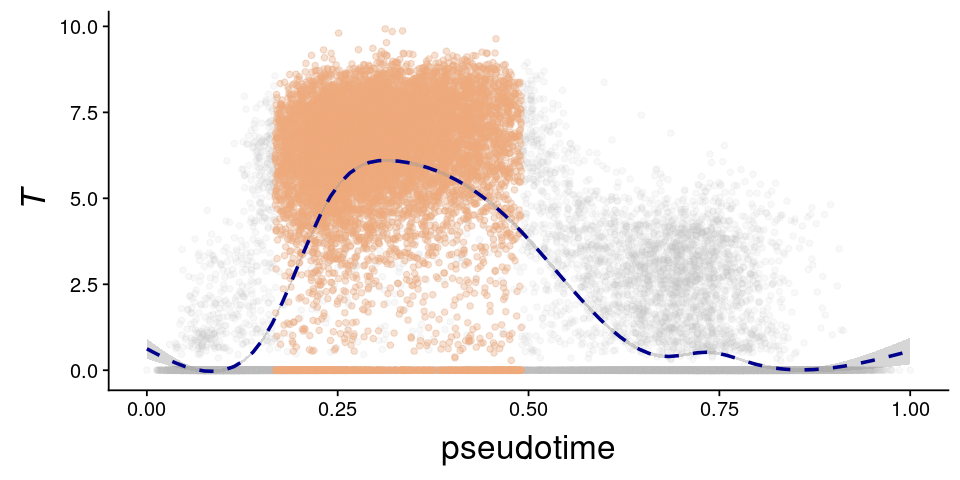

In [9]:
# plot stage definition : mesendo
df = cbind(p1, logcounts(sce)["ENSG00000164458_T",], sce$day)
colnames(df) = c("pseudotime","T","day")
df$scaled_pseudo <- range01(df$pseudotime)

options(repr.plot.width = 8, repr.plot.height = 4) 
ggplot(df, aes(x = scaled_pseudo, y = T, colour = day)) +
        geom_point(alpha = 0.4)  + xlab("pseudotime") +
        scale_color_canva(palette = "Pool party") + 
        stat_smooth(colour = "darkblue", linetype = 2) + theme(text = element_text(size = 20)) +
        theme(legend.position = "none") + theme(axis.title.y = element_text(face = "italic", size = 20))
ggplot(df, aes(x = scaled_pseudo, y = T, colour = day))  + 
        geom_point(alpha = 0.1, col = "grey")  + xlab("pseudotime") +
#         scale_color_canva(palette = "Pool party") + 
        geom_point(aes(x = scaled_pseudo, y = T), colour = col_mesendo,
               data = dplyr::filter(df, pseudotime > -23 & pseudotime < 4, day %in% c("day1","day2")),
                  alpha = 0.3) + theme(text = element_text(size = 20)) +
        theme(axis.title.y = element_text(face = "italic", size = 20)) + 
        stat_smooth(colour = "darkblue", linetype = 2) 

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


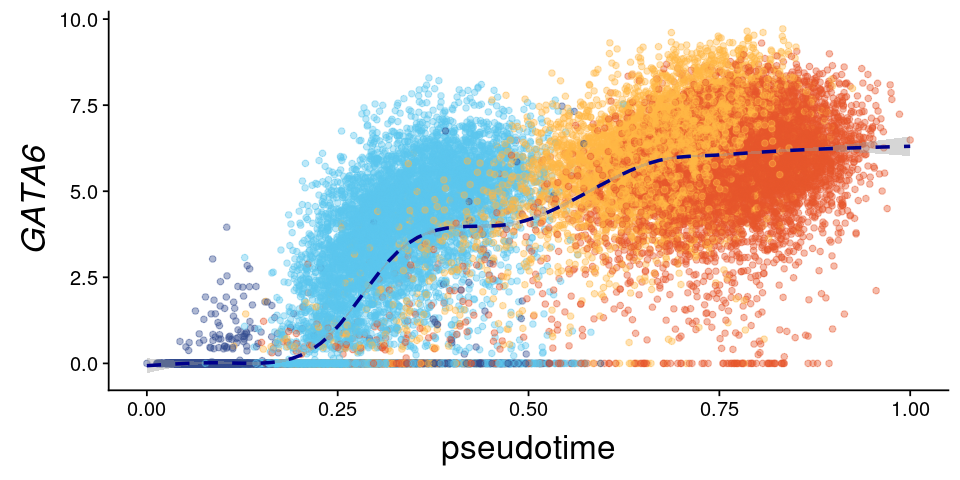

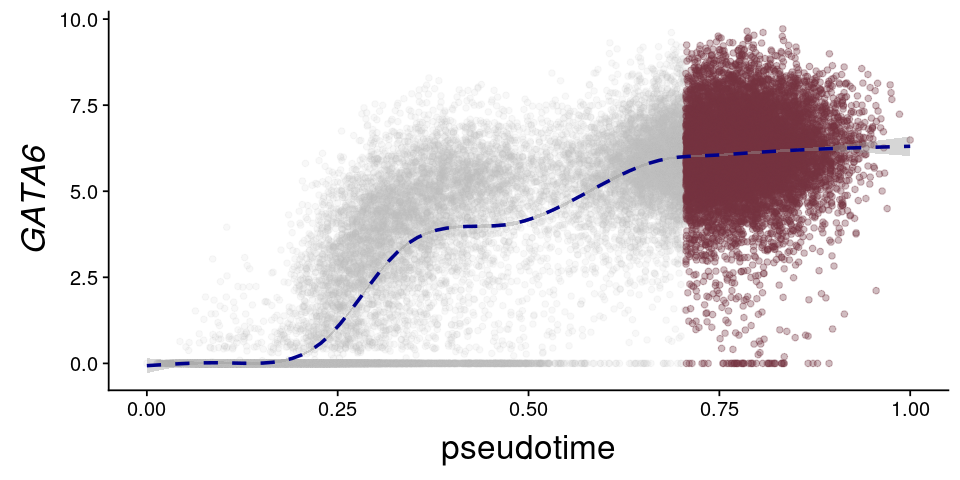

In [10]:
# plot stage definition : defendo
df = cbind(p1, logcounts(sce)["ENSG00000141448_GATA6",], sce$day)
colnames(df) = c("pseudotime","GATA6","day")
df$scaled_pseudo <- range01(df$pseudotime)

options(repr.plot.width = 8, repr.plot.height = 4) 
ggplot(df, aes(x = scaled_pseudo, y = GATA6, colour = day)) +
        geom_point(alpha = 0.4) + xlab("pseudotime") + theme(text = element_text(size = 20)) +
        scale_color_canva(palette = "Pool party") + theme(axis.title.y = element_text(face = "italic", size = 20)) +
        stat_smooth(colour = "darkblue", linetype = 2) + theme(legend.position = "none")
ggplot(df, aes(x = scaled_pseudo, y = GATA6, colour = day)) + 
        geom_point(alpha = 0.1, col = "grey") + xlab("pseudotime")   + 
        geom_point(aes(x = scaled_pseudo, y = GATA6), colour = col_defendo,
               data = dplyr::filter(df, pseudotime >  22, day %in% c("day2","day3")),
                  alpha = 0.3) + theme(text = element_text(size = 20)) +
        stat_smooth(colour = "darkblue", linetype = 2) + theme(axis.title.y = element_text(face = "italic", size = 20))

In [ ]:
## add more genes (show that stage definition not dependent on specific markers)

In [ ]:
## define known marker genes
pluri_markers <- c("ENSG00000111704_NANOG", "ENSG00000204531_POU5F1", 
                   "ENSG00000164362_TERT", "ENSG00000181449_SOX2",
                   "ENSG00000121570_DPPA4")
pluri_markers_select <- c("ENSG00000111704_NANOG", "ENSG00000204531_POU5F1", 
                          "ENSG00000181449_SOX2", "ENSG00000121570_DPPA4")
mesendo_markers <- c("ENSG00000164458_T", "ENSG00000163508_EOMES",
                     "ENSG00000185155_MIXL1")
defendo_markers <- c("ENSG00000121966_CXCR4", "ENSG00000136574_GATA4",
                     "ENSG00000141448_GATA6", "ENSG00000125798_FOXA2",
                     "ENSG00000164736_SOX17", "ENSG00000133937_GSC",
                     "ENSG00000147869_CER1", "ENSG00000132130_LHX1")
defendo_markers_select <- c("ENSG00000121966_CXCR4", "ENSG00000136574_GATA4",
                            "ENSG00000164736_SOX17", "ENSG00000141448_GATA6",
                            "ENSG00000147869_CER1", "ENSG00000132130_LHX1",
                           "ENSG00000133937_GSC")
later_markers <- c("ENSG00000152804_HHEX", "ENSG00000170608_FOXA3")
diff_genes <- c(pluri_markers, mesendo_markers, defendo_markers, later_markers)

pluri_gene_info <- read.table("/hps/nobackup/hipsci/scratch/singlecell_endodiff/resources/plurinet_gene_info.txt", header = T)

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


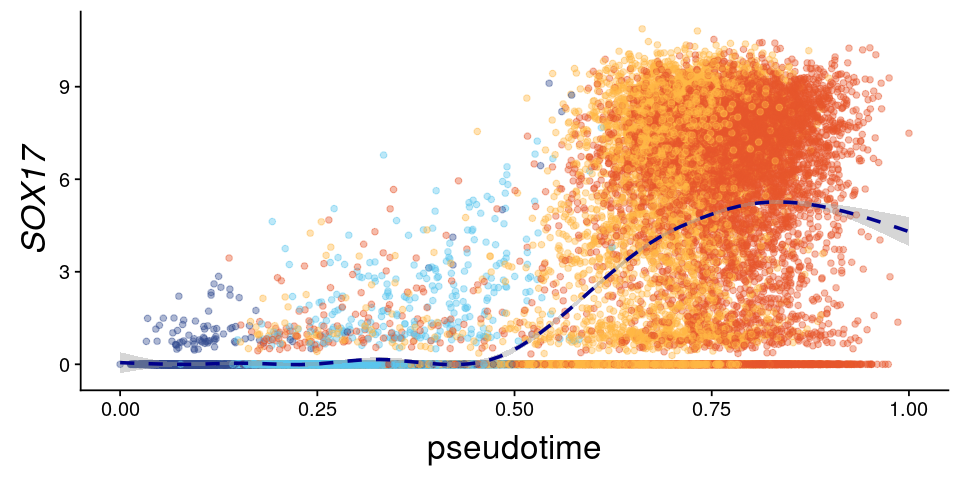

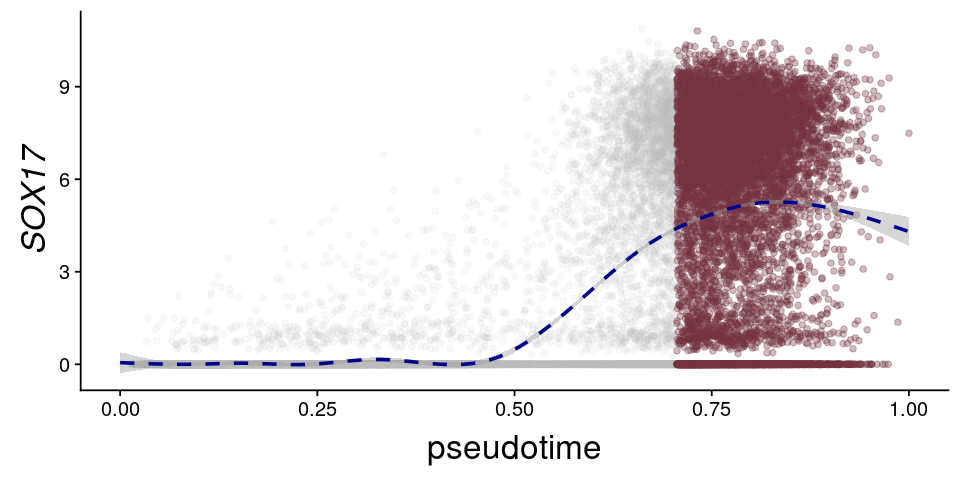

In [12]:
# plot stage definition : defendo
df = cbind(p1, logcounts(sce)["ENSG00000164736_SOX17",], sce$day)
colnames(df) = c("pseudotime","SOX17","day")
df$scaled_pseudo <- range01(df$pseudotime)

options(repr.plot.width = 8, repr.plot.height = 4) 
ggplot(df, aes(x = scaled_pseudo, y = SOX17, colour = day)) +
        geom_point(alpha = 0.4) + xlab("pseudotime") + theme(text = element_text(size = 20)) +
        scale_color_canva(palette = "Pool party") + theme(axis.title.y = element_text(face = "italic", size = 20)) +
        stat_smooth(colour = "darkblue", linetype = 2) + theme(legend.position = "none")
ggplot(df, aes(x = scaled_pseudo, y = SOX17, colour = day)) + 
        geom_point(alpha = 0.1, col = "grey") + xlab("pseudotime")   + 
        geom_point(aes(x = scaled_pseudo, y = SOX17), colour = col_defendo,
               data = dplyr::filter(df, pseudotime >  22, day %in% c("day2","day3")),
                  alpha = 0.3) + theme(text = element_text(size = 20)) +
        stat_smooth(colour = "darkblue", linetype = 2) + theme(axis.title.y = element_text(face = "italic", size = 20))

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


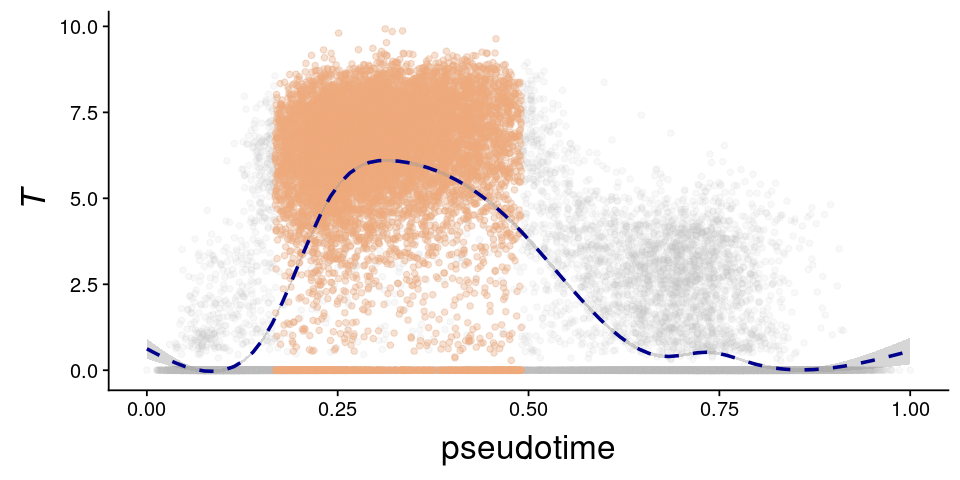

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


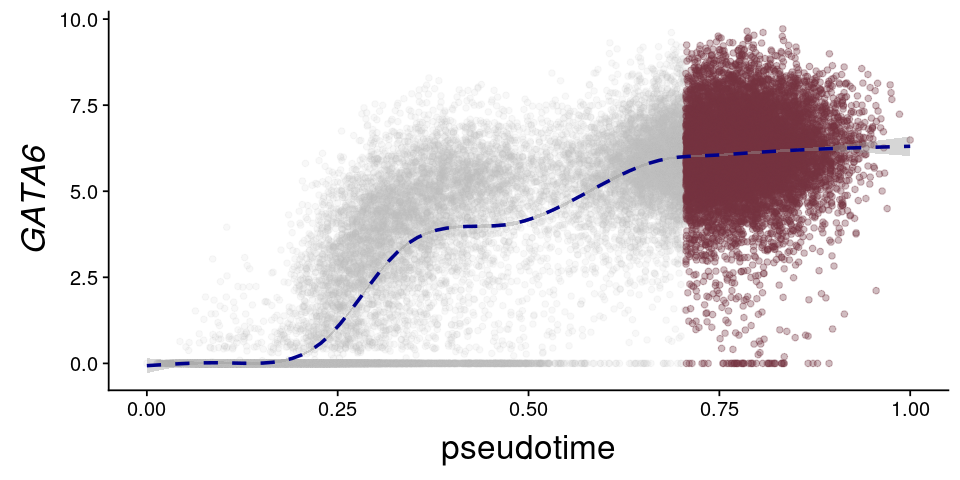

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


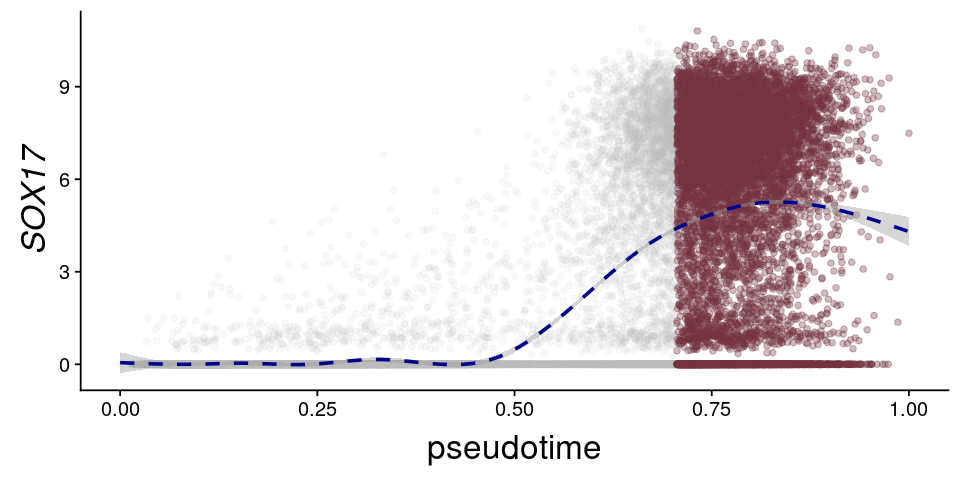

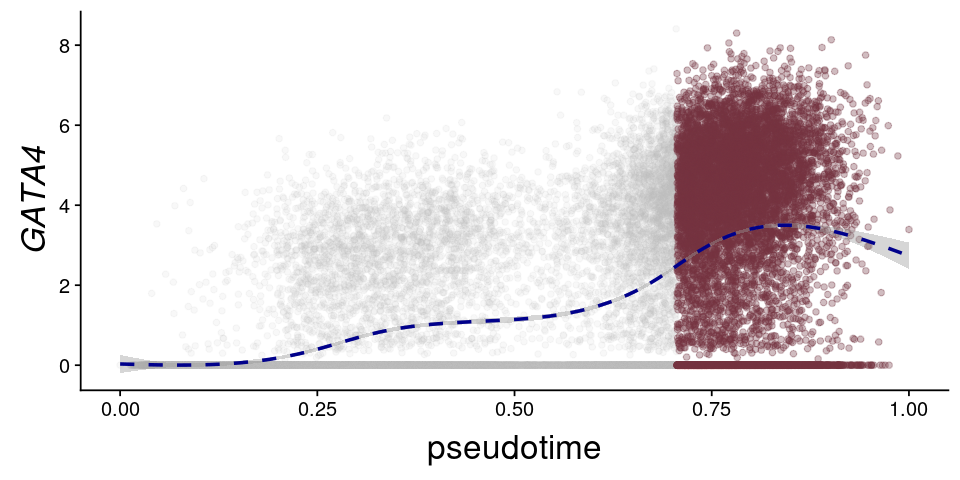

In [14]:
df = cbind(p1, logcounts(sce)["ENSG00000164458_T",], sce$day)
colnames(df) = c("pseudotime","T","day")
df$scaled_pseudo <- range01(df$pseudotime)
ggplot(df, aes(x = scaled_pseudo, y = T, colour = day))  + 
        geom_point(alpha = 0.1, col = "grey")  + xlab("pseudotime") +
#         scale_color_canva(palette = "Pool party") + 
        geom_point(aes(x = scaled_pseudo, y = T), colour = col_mesendo,
               data = dplyr::filter(df, pseudotime > -23 & pseudotime < 4, day %in% c("day1","day2")),
                  alpha = 0.3) + theme(text = element_text(size = 20)) +
        theme(axis.title.y = element_text(face = "italic", size = 20)) + 
        stat_smooth(colour = "darkblue", linetype = 2) 
#
df = cbind(p1, logcounts(sce)["ENSG00000141448_GATA6",], sce$day)
colnames(df) = c("pseudotime","GATA6","day")
df$scaled_pseudo <- range01(df$pseudotime)
ggplot(df, aes(x = scaled_pseudo, y = GATA6, colour = day)) + 
        geom_point(alpha = 0.1, col = "grey") + xlab("pseudotime")   + 
        geom_point(aes(x = scaled_pseudo, y = GATA6), colour = col_defendo,
               data = dplyr::filter(df, pseudotime >  22, day %in% c("day2","day3")),
                  alpha = 0.3) + theme(text = element_text(size = 20)) +
        stat_smooth(colour = "darkblue", linetype = 2) + theme(axis.title.y = element_text(face = "italic", size = 20))
#
df = cbind(p1, logcounts(sce)["ENSG00000164736_SOX17",], sce$day)
colnames(df) = c("pseudotime","SOX17","day")
df$scaled_pseudo <- range01(df$pseudotime)
ggplot(df, aes(x = scaled_pseudo, y = SOX17, colour = day)) + 
        geom_point(alpha = 0.1, col = "grey") + xlab("pseudotime")   + 
        geom_point(aes(x = scaled_pseudo, y = SOX17), colour = col_defendo,
               data = dplyr::filter(df, pseudotime >  22, day %in% c("day2","day3")),
                  alpha = 0.3) + theme(text = element_text(size = 20)) +
        stat_smooth(colour = "darkblue", linetype = 2) + theme(axis.title.y = element_text(face = "italic", size = 20))
#
df = cbind(p1, logcounts(sce)["ENSG00000136574_GATA4",], sce$day)
colnames(df) = c("pseudotime","GATA4","day")
df$scaled_pseudo <- range01(df$pseudotime)
ggplot(df, aes(x = scaled_pseudo, y = GATA4, colour = day)) + 
        geom_point(alpha = 0.1, col = "grey") + xlab("pseudotime")   + 
        geom_point(aes(x = scaled_pseudo, y = GATA4), colour = col_defendo,
               data = dplyr::filter(df, pseudotime >  22, day %in% c("day2","day3")),
                  alpha = 0.3) + theme(text = element_text(size = 20)) +
        stat_smooth(colour = "darkblue", linetype = 2) + theme(axis.title.y = element_text(face = "italic", size = 20))

In [ ]:
### look at elf2 for Marc

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


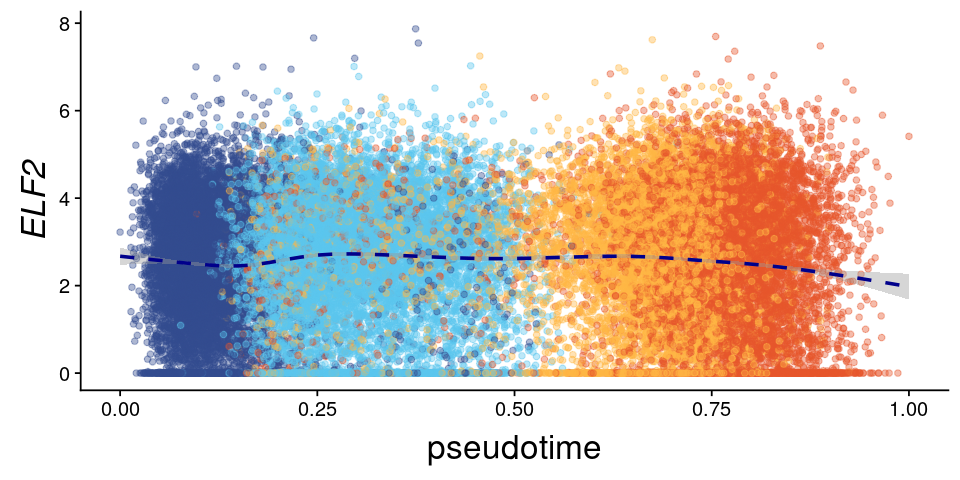

In [28]:
df = cbind(p1, logcounts(sce)["ENSG00000109381_ELF2",], sce$day)
colnames(df) = c("pseudotime","ELF2","day")
df$scaled_pseudo <- range01(df$pseudotime)
ggplot(df, aes(x = scaled_pseudo, y = ELF2, colour = day)) +
        geom_point(alpha = 0.4) + xlab("pseudotime") + theme(text = element_text(size = 20)) +
        scale_color_canva(palette = "Pool party") + theme(axis.title.y = element_text(face = "italic", size = 20)) +
        stat_smooth(colour = "darkblue", linetype = 2) + theme(legend.position = "none")

In [27]:
table(sce[,sce$day == "day0"]$donor_short_id)


aowh_2 aoxv_3 babz_3 bezi_1 bokz_5 cicb_2 ciwj_2 cuhk_2 datg_2 eesb_1 eipl_1 
    88     68     28     13    159     42     40     41    185     66     99 
eiwy_1 eoxi_6 fasu_2 fawm_2 feec_2 fejf_2 guss_1 guyj_2 hajc_1 hayt_1 hecn_3 
    25     22     20     49     75     63    293    185    130     41    163 
hegp_3 heth_1 hoik_1 iezw_2 iisa_1 iisa_3 iiyk_4 iudw_4 jejf_2 jogf_2 joxm_1 
    22     54     32     30     39     38     94     44    107    102    383 
juuy_2 kajh_3 kefb_1 keui_1 kolf_2 kucg_2 kuco_1 kuxp_1 laey_4 lepk_1 letw_1 
   132     55     67     40     73     72     95     84     27     35    316 
liqa_1 lise_3 melw_2 meue_4 miaj_6 mita_2 naah_2 naju_1 nocf_2 nosn_6 nudd_1 
   110     62    101    137     56     35     61     25    131     73    286 
nufh_3 oaqd_3 oebj_1 oibg_1 oicx_6 oikd_2 oilg_3 oojs_1 paab_4 pahc_4 pelm_3 
    99     80     40    103     34     15     44     40    166     61    222 
pipw_5 poih_4 puie_5 pulk_1 qaqx_1 qayj_3 qehq_3 qoog_4 qorq_2 